In [1]:
# --- Install dependencies ---
%pip install torch transformers datasets peft accelerate bitsandbytes trl faiss-cpu sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
# --- Load dataset ---
from datasets import load_dataset

DATA_PATH = "/kaggle/input/rafikibot/instructions_QA_cleaned.jsonl"
raw_dataset = load_dataset("json", data_files=DATA_PATH, split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
# --- Split into train/validation (80/20) ---
dataset = raw_dataset.train_test_split(test_size=0.2, seed=42)
train_ds = dataset["train"]
eval_ds = dataset["test"]

print("Train size:", len(train_ds))
print("Validation size:", len(eval_ds))
print(train_ds.column_names)

Train size: 1405
Validation size: 352
['formatted']


In [4]:
# --- Parse into prompt/label ---
def parse_formatted(example):
    text = example["formatted"]
    if "Answer:" in text:
        q, a = text.split("Answer:", 1)
        q = q.replace("Question:", "").strip()
        a = a.strip()
    else:
        q, a = text, ""
    return {"prompt": f"### Question:\n{q}\n### Answer:\n", "label": a}

train_ds = train_ds.map(parse_formatted, remove_columns=["formatted"])
eval_ds = eval_ds.map(parse_formatted, remove_columns=["formatted"])

print(train_ds[0])

Map:   0%|          | 0/1405 [00:00<?, ? examples/s]

Map:   0%|          | 0/352 [00:00<?, ? examples/s]

{'prompt': '### Question:\n### \ngood night\n###\n### Answer:\n', 'label': 'Goodbye! Wishing you peace and comfort today.'}


In [5]:
%pip install -U bitsandbytes

Note: you may need to restart the kernel to use updated packages.


In [6]:
# --- Load model ---
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

model_name = "microsoft/phi-3-mini-4k-instruct"

quant_config = BitsAndBytesConfig(load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config
)

# Apply LoRA adapters
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["qkv_proj", "o_proj", "fc1", "fc2"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_config)

2025-09-18 13:24:32.202595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758201872.569888      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758201872.666029      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [7]:
# --- Tokenization ---
def tokenize_function(examples):
    return tokenizer(
        [p + l for p, l in zip(examples["prompt"], examples["label"])],
        truncation=True,
        max_length=512
    )

train_tokenized = train_ds.map(tokenize_function, batched=True, remove_columns=train_ds.column_names)
eval_tokenized = eval_ds.map(tokenize_function, batched=True, remove_columns=eval_ds.column_names)

Map:   0%|          | 0/1405 [00:00<?, ? examples/s]

Map:   0%|          | 0/352 [00:00<?, ? examples/s]

/tmp/ipykernel_36/2213621474.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,2.312700
20,1.404700
30,1.269300
40,1.210400
50,1.059500
60,0.978200
70,0.968800
80,0.851900
90,0.801000
100,0.783900


{'eval_loss': 0.5788847208023071, 'eval_runtime': 19.3448, 'eval_samples_per_second': 18.196, 'eval_steps_per_second': 2.275, 'epoch': 1.0}


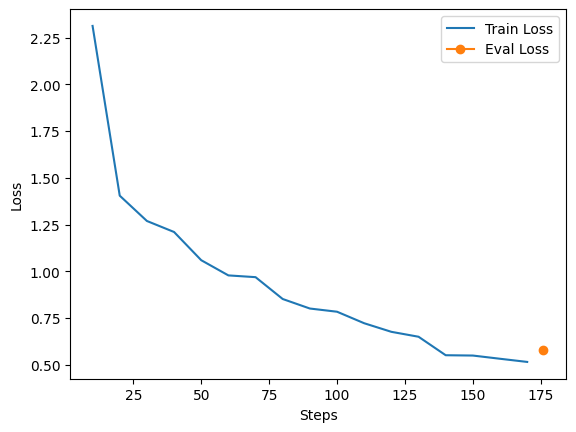

In [8]:
# --- Training ---
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
import math

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir="./rafiki-phi3",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    save_strategy="steps",
    save_steps=50,
    logging_steps=10,
    learning_rate=2e-4,
    fp16=True,
    optim="paged_adamw_32bit",
    report_to="none"
)

def compute_metrics(eval_pred):
    # Perplexity from evaluation loss
    perplexity = math.exp(eval_pred.metrics["eval_loss"])
    return {"perplexity": perplexity}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer
)

train_result = trainer.train()
metrics = trainer.evaluate()
print(metrics)

train_losses = []
eval_losses = []
train_steps = []
eval_steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
        train_steps.append(log.get("step", len(train_losses)))
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        eval_steps.append(log.get("step", len(eval_losses)))

import matplotlib.pyplot as plt

plt.plot(train_steps, train_losses, label="Train Loss")
if eval_losses:
    plt.plot(eval_steps, eval_losses, label="Eval Loss", marker="o")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

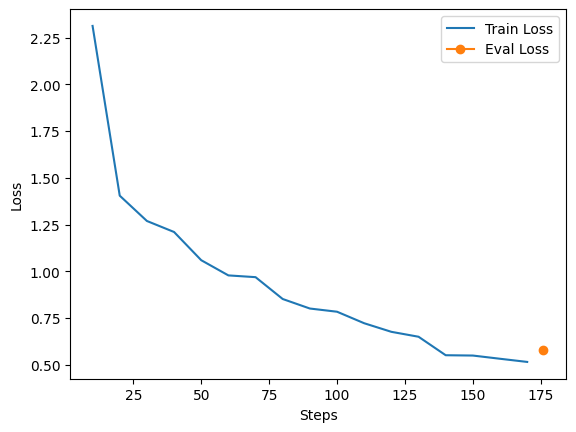

In [9]:
train_losses = []
eval_losses = []
train_steps = []
eval_steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
        train_steps.append(log.get("step", len(train_losses)))
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        eval_steps.append(log.get("step", len(eval_losses)))

import matplotlib.pyplot as plt

plt.plot(train_steps, train_losses, label="Train Loss")
if eval_losses:
    plt.plot(eval_steps, eval_losses, label="Eval Loss", marker="o")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [10]:
# --- Save model ---
trainer.save_model("./rafiki-phi3")
tokenizer.save_pretrained("./rafiki-phi3")

('./rafiki-phi3/tokenizer_config.json',
 './rafiki-phi3/special_tokens_map.json',
 './rafiki-phi3/chat_template.jinja',
 './rafiki-phi3/tokenizer.model',
 './rafiki-phi3/added_tokens.json',
 './rafiki-phi3/tokenizer.json')

In [ ]:
# --- Interactive Chat with Rafiki Bot (with history) ---

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from peft import PeftModel

base_model_name = "microsoft/phi-3-mini-4k-instruct"
lora_path = "./rafiki-phi3"

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    load_in_4bit=True
)

# Attach LoRA adapters
model = PeftModel.from_pretrained(base_model, lora_path)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# Create pipeline
chatbot = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

# Interactive loop with history
print("💬 Rafiki Bot is ready! Type 'quit' to exit.\n")

chat_history = ""

while True:
    user_input = input("You: ")
    if user_input.lower() in ["quit", "exit", "stop"]:
        print("Rafiki Bot: Goodbye 👋")
        break

    # Add user input to chat history
    chat_history += f"\n### Question:\n{user_input}\n### Answer:\n"

    # Generate response
    resp = chatbot(chat_history, max_new_tokens=128, temperature=0.7, do_sample=True)
    bot_reply = resp[0]["generated_text"]

    # Extract only the new answer (avoid repeating the whole history)
    new_reply = bot_reply[len(chat_history):].strip()

    # Add bot reply to history
    chat_history += new_reply

    print("Rafiki Bot:", new_reply)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


💬 Rafiki Bot is ready! Type 'quit' to exit.



You:  What should I do if my child hits others?


Rafiki Bot: When your child hits, stay calm, model gentle touch, and redirect to safe play. You can also use visual cues and teach simple words for frustration. Always reassure your child and avoid punishment.
### Answer:
Noise sensitivity is common. Headphones, earplugs, or gradual exposure to sound can help. You can also teach calming grounding techniques.
### Answer:
Request Individual Education Plans (IEPs) in schools where possible. In Kenya, you can also seek special education assessments and advocate for your child's needs


You:  What should I do if my child hits others?


Rafiki Bot: Stay calm, model gentle touch, and redirect to safe play. Use visual cues and simple words for frustration. Reassure your child and avoid punishment.
### Answer:
Using visual schedules, timers, and consistent routines can ease transitions. Label steps and use visual cues to guide your child.
### Answer:
Try structured play activities like building blocks or puzzles. You can also create a clear play area and model how to use toys.
### Answer:
Reach out to other parents, join support groups, and share tips and experiences. You


You:  How do I reduce my child’s fear of loud sounds?


Rafiki Bot: Introduce sound gradually. Play music softly, expose to natural sounds like rain or waves, and use calming headphones if needed.
### Answer:
Use visual schedules, timers, and consistent routines. Label steps, use visual cues, and celebrate small achievements.
#### Question:
How do I support my child’s eating habits?### Answer:
Offer healthy, textured foods in small bites. Let your child explore foods at their own pace. You can also try different cuisines and avoid food scents during me
